In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from backtest_functions_v2 import *

### aggregation

In [9]:
df = pd.read_parquet("../data/5b.cryptonews_topic_sentiment.parquet")
df.index = pd.to_datetime(df['date'])
df.index = df.index.tz_convert(None)
# df = df.drop(columns=['date', 'title', 'text', 'news_text_title'])
df.head(3)

,title,text,source_name,date,topic,topic_confidence_score,news_text_title,sentiment_finbert,score_finbert,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,People,Organizations,Cryptocurrencies,Events
date,,,,,,,,,,,,,,,,,,,
2021-01-02 00:20:00,2021 Bitcoin Price Predictions: Is The Massive...,As the bitcoin price hovers under the psycholo...,Forbes,2021-01-02 00:20:00+00:00,"liquidity, volatility, price action, price mov...",0.238574,2021 Bitcoin Price Predictions: Is The Massive...,neutral,0.876394,0.5,0.0,0.0,0.0,0.0,0.0,[],[],[Bitcoin],[]
2021-01-01 20:31:35,Will Central Banks Hold Bitcoin in 2021?,Central banks (CB) will hold bitcoin sooner or...,BeInCrypto,2021-01-01 20:31:35+00:00,consensus updates,0.199005,Will Central Banks Hold Bitcoin in 2021? Centr...,neutral,0.916949,0.0,0.5,0.0,0.0,0.7,0.0,[Krüger],[Central banks],[Bitcoin],[]
2021-01-01 19:15:02,"Bitcoin Is Digital Social Justice, feat. Tyron...",The podcaster and CEO of Onramp Invest discuss...,Coindesk,2021-01-01 19:15:02+00:00,social platforms,0.299585,"Bitcoin Is Digital Social Justice, feat. Tyron...",neutral,0.903567,0.0,0.3,0.0,0.5,0.7,0.0,[Tyrone Ross],[Onramp Invest],[Bitcoin],[]


In [10]:
print('df length:', len(df), '\n')

people_freq = df['People'].explode().value_counts()
print(people_freq.head())

print()

organizations_freq = df['Organizations'].explode().value_counts()
print(organizations_freq.head())

df.drop(columns=['People', 'Organizations', 'Cryptocurrencies', 'Events'], inplace=True)

df length: 155376 

People
Michael Saylor    2467
Elon Musk         1670
Donald Trump      1615
Peter Schiff       969
Sally Ho           940
Name: count, dtype: int64

Organizations
SEC              4413
MicroStrategy    3785
BlackRock        3301
Binance          2194
Coinbase         2174
Name: count, dtype: int64


In [11]:
# process finbert sentiment

sentiment_mapping = {
  'positive': 1,
  'neutral': 0,
  'negative': -1
}
df['sentiment_finbert'] = df['sentiment_finbert'].map(sentiment_mapping)
df['sentiment_finbert'] = df['sentiment_finbert'] * df['score_finbert']
df.drop(columns=['score_finbert'], inplace=True)

In [23]:
print('df length:', len(df))
df['topic'].value_counts().head(15)

# To advoid correlated features and overfitting, we are not using this

df length: 155376


topic
liquidity, volatility, price action, price movement, trading    59585
market sentiment                                                31932
exchange traded funds, ETF                                      13107
consensus updates                                               10281
technical infrastructure                                         5498
legal proceedings                                                4226
social platforms                                                 4145
whale activity, large transaction                                3890
institutional investments                                        3877
product launches                                                 3725
government policy                                                3531
sustainability, renewable, environmental                         1683
nft, metaverse, virtual world                                    1599
treasury, reserve                                                1353
mining technol

In [12]:
# group by date

aggregation_dict = {
  'tanalysis_absa': 'mean',
  'economy_absa': 'mean',
  'regulation_absa': 'mean',
  'technology_absa': 'mean',
  'adoption_absa': 'mean',
  'cybersecurity_absa': 'mean',
  'sentiment_finbert': 'mean'
}

df_grouped = df.groupby(pd.Grouper(freq='H')).agg(aggregation_dict)
df_grouped['news_count'] = df.groupby(pd.Grouper(freq='H')).size()
df_grouped

,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,cybersecurity_absa,sentiment_finbert,news_count
date,,,,,,,,
2021-01-01 06:00:00,0.850000,0.0,0.0,0.0,0.15,0.0,0.465736,2
2021-01-01 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2021-01-01 08:00:00,0.400000,0.0,0.0,0.0,0.50,0.0,0.043323,2
2021-01-01 09:00:00,-0.050000,0.0,0.0,0.0,0.40,0.0,0.732153,2
2021-01-01 10:00:00,0.766667,0.0,0.0,0.0,0.30,0.0,0.830230,3
...,...,...,...,...,...,...,...,...
2025-01-01 00:00:00,0.000000,0.0,0.0,0.0,0.00,0.0,0.133671,4
2025-01-01 01:00:00,0.000000,0.0,0.0,0.0,0.00,0.0,0.935469,1
2025-01-01 02:00:00,0.000000,0.0,0.0,0.0,0.00,0.0,-0.016161,2


### baseline strategies

Overall Annual Return: 142.84%
Overall Annual Sharpe Ratio: 3.3245
Maximum Drawdown: -15.82 %
Alpha: 1.7899
Beta: -0.142

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2021       0.181354    0.387657    -0.122651      0.546311       0.621690
1  2022       2.130711    0.286994    -0.301348      0.578471       4.120684
2  2023       1.348660    0.143182     0.178720      0.389067       6.034927
3  2024       3.107235    0.182711     0.120399      1.269380       7.823913


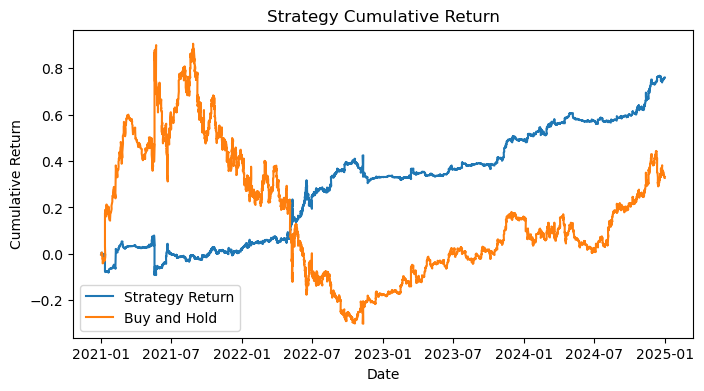

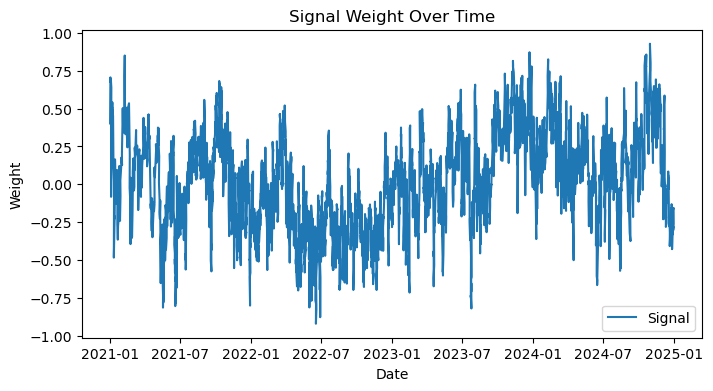

In [24]:
cols = ['tanalysis_absa', 'economy_absa', 'regulation_absa', 'technology_absa', 'adoption_absa', 'cybersecurity_absa', 'sentiment_finbert']
df['signal'] = df[cols].mean(axis=1)

# signal smoothing
df['signal'] = df['signal'].ewm(span=100).mean()

# signal scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
df['signal'] = scaler.fit_transform(df['signal'].values.reshape(-1, 1))

run_backtest(df, freq='h')
